# Introduction
The primary goal of this notebook is to create a model that can differentiate between different classes of prescription medications given their images.

### Data
I got most of my data from pillbox.nlm.nih.gov and by scraping Google images. The website provides labels on over 8000 medications. Because my main goal is using the pictures in a classification app, I'm only taking the front view of the pills because that is intuitively the side of the pill that would contain identification information.

**Note:** There are sometimes 10-20 different generic versions of the same medication, so I only used the brand name counterparts in this example. In addition, I chose to only use 5 different classes (the most popular and well-known medications) because it was relatively easy to find a variety of different images for these medications. However, the concept is the same for more medications, and I will likely retrain this model to include more medications when I am able to find the data.  

The medications are: Viagra, Xanax, Oxycontin, Lyrica, and Valtrex.  

In this notebook, I use an older version of FastAi. The cells below set up the fastai requirements I used when I ran this notebook in Google Colab (Unfortunately I don't own an Nvidia CPU).

In [0]:
!pip install Pillow==5.3.0
!pip install "fastai==0.7.0"
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install image
!pip install torchtext==0.2.3
!pip install seaborn --upgrade matplotlib
!pip install seaborn --upgrade pandas
!pip install seaborn --upgrade pillow
!pip install seaborn --upgrade plotly

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from google.colab import drive, files
%matplotlib inline

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Default Variables and Locations
PATH = '/content/drive/My Drive/Datasets/data' 
sz = 240 #Size of the Image
arch = resnet34 #We're going to use Resnet 34's architecture.
bs =32 #Batch Size used when training

In [0]:
data = ImageClassifierData.from_paths(PATH,bs=16, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf = learn.lr_find()

 96%|█████████▋| 26/27 [00:17<00:00,  2.31it/s, loss=29.4]

**Finding the Optimal Learning Rate**  
It turns out that we can plot the loss for each learning rate and choose one where the slope of the graph is decreasing greatest. This allows us to find a learning rate small enough where we are able to find a good minima in our loss function but large enough where training doesn't take an eternity. In the graph below, it looks as though the slope is steeply negative around 0.1.

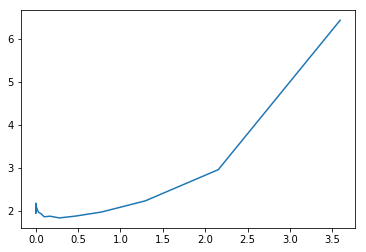

In [0]:
plt.plot(learn.sched.lrs, learn.sched.losses)

# Training the Model
TFMS is an aggregate of augmentation functions that flip, zoom, crop, and shift the images at random. You can view that documentation at https://docs.fast.ai/  
In this example we also use Resnet 34's architechture with weights pretrained on ImageNet. I found that retraining a robust model on images in my domain resulted in much less variation and much higher accuracy.  

**Differential Learning Rate**
The next step was to unfreeze the layers of the pretrained model so we could adjust the weights. We use differential learning rates in order to train different layers of the model at different learning rates. The earlier layers account for weights obtained from simple characteristics such as shadows and edges which exist in almost all image data, so we can train these layers with a much lower learning rate that increases as we get to the later layers.

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)


def get_augs():
  data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]


data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data)
learn.unfreeze()
lr=np.array([1e-5, 1e-3, 1e-1])
learn.fit(lr, 2, cycle_len=3, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.365713   1.433449   0.758621  
    1      1.150554   0.73886    0.87931   
    2      0.945696   0.562848   0.87931   
    3      0.766356   0.723755   0.862069  
    4      0.792576   0.13025    0.965517  
    5      0.681587   0.278866   0.931034  
    6      0.609519   0.245236   0.931034  
    7      0.495917   0.174535   0.913793  
    8      0.440541   0.151549   0.913793  



[array([0.15155]), 0.9137931055036085]

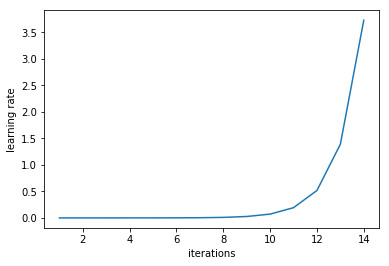

In [0]:
learn.sched.plot_lr()

In [0]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9482758620689655

# Evaluation

[[10  1  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0 16  0  0]
 [ 2  0  0  7  0]
 [ 0  0  0  0 11]]


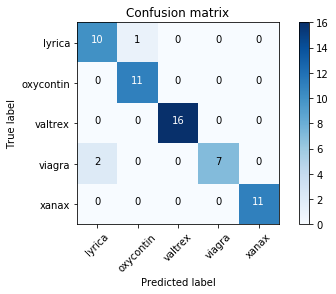

In [0]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

Confusion matrix shows only 2 medications which are incorrectly identified. Below are visualizations of what the model predicted vs actual.

I also collected a different set of images of the 5 classes and used used the same transformations on them to work as a test-set.

In [0]:
viagratest = '/content/drive/My Drive/Datasets/drugs/drugpics/12.jpg' #image of a viagra pill
trn_tfms, val_tfms = tfms_from_model(arch,sz)
im = val_tfms(cv2.imread(deltatest)/255)
preddelta = learn.predict_array(im[None])
learn.data.classes[np.argmax(preddelta)]

'viagra'

Below we will assess what images the model found were most difficult or easy to classify.

In [0]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)


def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)


def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        ims[i] = cv2.resize(ims[i], (300,200))
        plt.imshow(ims[i])
        
        
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(os.path.join(PATH,ds.fnames[idx])))


def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')
  
  
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]


def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most Correct


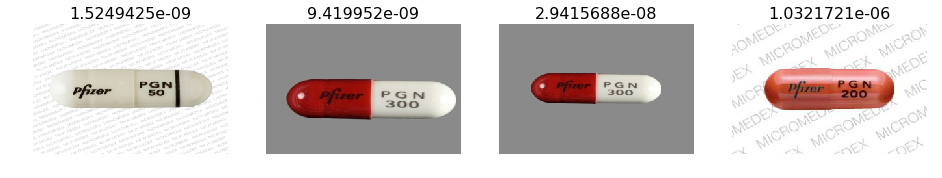

Most Correct


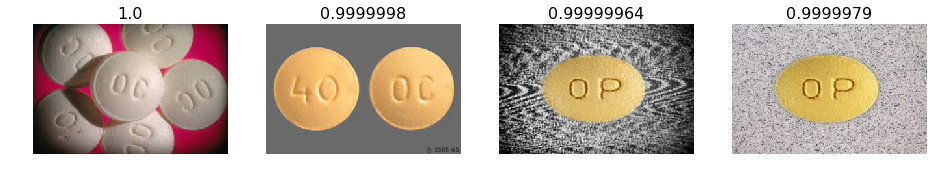

Most Correct


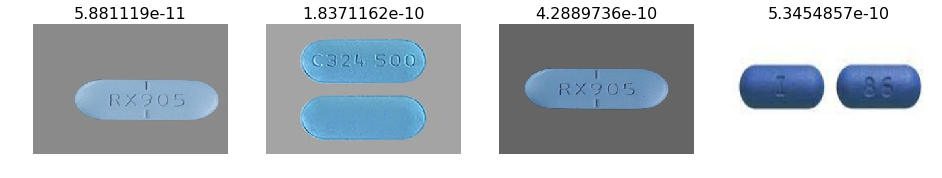

Most Correct


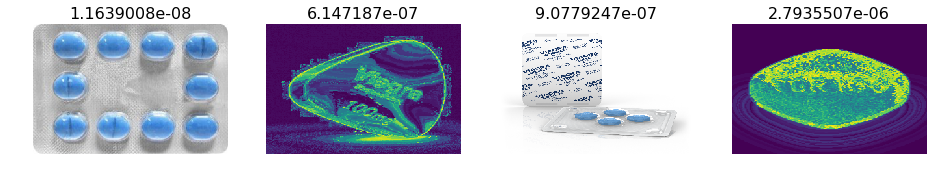

Most Correct


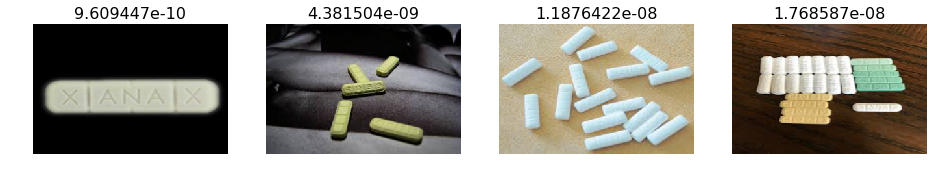

In [0]:
plot_val_with_title(most_by_correct(0, True), 'Most Correct')
plt.show()
plot_val_with_title(most_by_correct(1, True), 'Most Correct')
plt.show()
plot_val_with_title(most_by_correct(2, True), 'Most Correct')
plt.show()
plot_val_with_title(most_by_correct(3, True), 'Most Correct')
plt.show()
plot_val_with_title(most_by_correct(4, True), 'Most Correct')
plt.show()

Most Correct


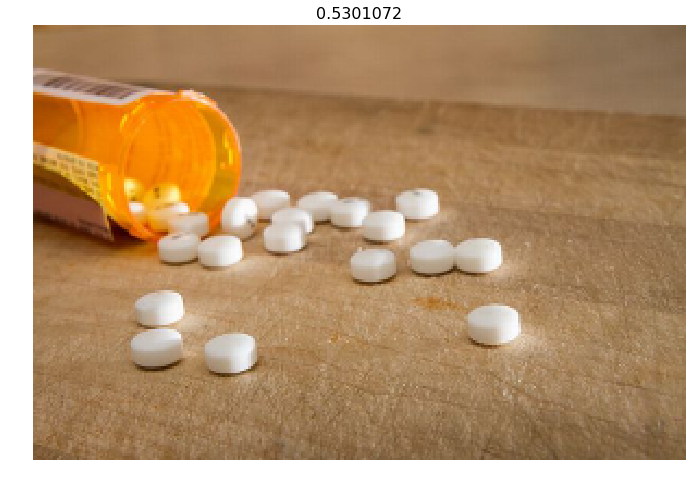

Most Correct
Not Found.
Most Correct
Not Found.
Most Correct


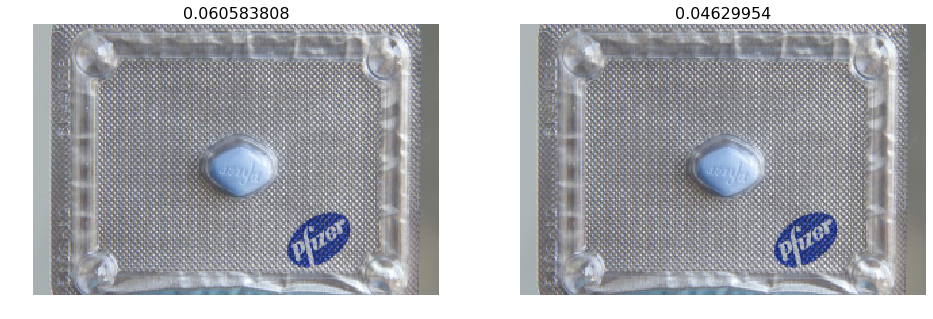

Most Correct
Not Found.


In [0]:
plot_val_with_title(most_by_correct(0, False), 'Most Incorrect Lyrica')
plt.show()
plot_val_with_title(most_by_correct(1, False), 'Most Incorrect Oxycontin')
plt.show()
plot_val_with_title(most_by_correct(2, False), 'Most Incorrect Valtrex')
plt.show()
plot_val_with_title(most_by_correct(3, False), 'Most Incorrect Viagra')
plt.show()
plot_val_with_title(most_by_correct(4, False), 'Most Incorrect Xanax')
plt.show()

Most uncertain predictions


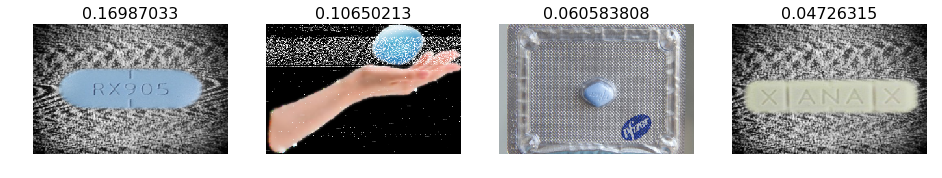

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[1:5]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Conclusion
The model is able to classify drugs correctly 95-98% of the time! However, this is not good enough for production because it deals with people's health. Improvements can be made by adding more variations of each drugs and maybe changing the loss functions. Ensemble learning and one-shot learning are also an option because of the low availability of images. I'm still unsure how much augmentations actually help the accuracy of the model.  

In the future, I want to be able to add more classes, including those of generic medications. The main obstacle to doing so is getting enough variations in images of each pill. There are thousands of types of medications, scores of dosages, and dozens of manufacturers making each of those. This creates an enormously large amount of required data that has to be manually collected. Images of medications online are often only from one angle and as such, do not represent the images that consumers would take.